# Poisson equation in 2D: joint estimation of the solution and the diffusion 

Consider the following PDE on $\Omega=[0,1]^2$:
$$
\begin{cases}
-\nabla(a(x,y)\nabla u(x,y)) = f(x, y),\\
f(x,y)=\frac{2\pi^2\sin\pi x\sin\pi y}{1+x^2+y^2+(x-1)^2+(y-1)^2}+
\frac{2\pi((2x-1)\cos\pi x\sin\pi y+(2y-1)\sin\pi x\cos \pi y)}{(1+x^2+y^2+(x-1)^2+(y-1)^2)^2}, \text{ (source term)}.
\end{cases}
$$
On ther boundary $\partial\Omega$ we set
$$
a(x,y) = \frac{1}{1+x^2+y^2+(x-1)^2+(y-1)^2}.
$$

We get that the true solution on $\Omega$ that we will estimate with a PINN is 
$$
u(x,y)=\sin\pi x\sin\pi y.
$$
The ground truth on $\Omega$ of the diffusion coefficient is
$$
a(x,y) = \frac{1}{1+x^2+y^2+(x-1)^2+(y-1)^2}.
$$

This is a **jinns** reimplementation of the inverse problem studied in [this article](https://arxiv.org/pdf/2306.08827.pdf) for example, the original code is available [here](https://github.com/i207M/PINNacle/blob/main/src/pde/inverse.py#L58).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
import numpy as np
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

## Observations

We simulate some observations

In [5]:
def u_true(x):
    return jnp.sin(jnp.pi * x[0]) * jnp.sin(jnp.pi * x[1])
v_u_true = vmap(u_true)

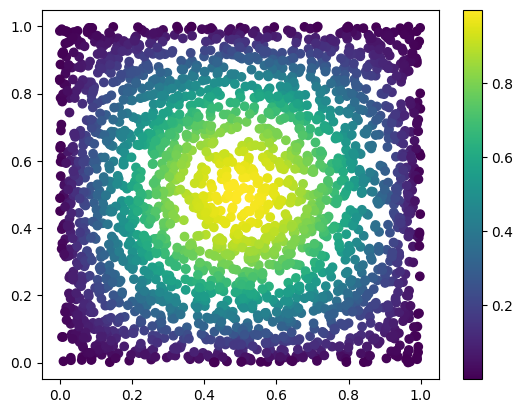

In [6]:
key, subkey = jax.random.split(key)
n_obs = 2500
x = jax.random.uniform(subkey, shape=(n_obs, 2), minval=0.0, maxval=1.0)
obs = v_u_true(x)

obs_batch = jnp.concatenate([
    x[..., 0:1], x[..., 1:2], obs[..., None]
    ], axis=-1)

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


__Optionally blur the observed values__

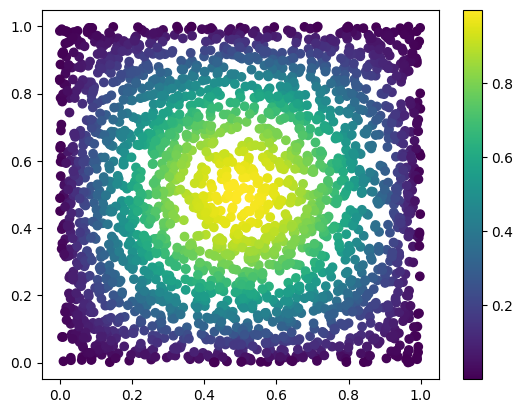

In [7]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] +
    0 #random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


Create the neural network architecture for the PINN. The network will have two outputs:

- $u(x,y)$, the classical PINN output
- $a(x, y)$. This secondary PINN output should then be treated as the diffusion coefficient, i.e., an equation parameter. In **jinns**, we know that the equation parameters are fed through the dictionary `params["eq_params"]`. If we want one of the equation parameters to be taken as a PINN output, one then needs to specify a transform with the `eq_params_heterogeneity` argument. See below in the loss construction.

In [8]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 2]
]

key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2, slice_solution=jnp.s_[:1])
init_nn_params = u.init_params()

In [9]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "a":0. # The second output of the PINN will correspond to the diffusion coefficient, so the value here is irrelevant
    }
}

Create a DataGenerator object

In [10]:
n = 500
nb = 320
omega_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDEStatio(
    subkey,
    n,
    nb,
    omega_batch_size,
    omega_border_batch_size,
    dim,
    (xmin, xmin),
    (xmax, xmax),
    method
)

## Loss construction

Create the 2D Poisson loss. The loss contains **heterogeneous parameters** that can be managed in two steps:

1. Define a dictionary `eq_params_heterogeneity` with any kind of functions that should be applied to the equation parameters. Here, the diffusion parameter (`params["eq_params"]["a"]`) is set to the second output of the PINN with a custom transform function that we give at key `"a"` of the `eq_params_heterogeneity` dictionary. Note that whatever the transform, the arguments of the such a function must be `x, u, params` in the stationary case.

2. Transform the parameters according to the content of the dictionary `eq_params_heterogeneity` at each call to `evaluate`. This can be done simply by decorating the `evaluate()` method with `@evaluate_heterogeneous_parameters`. The equivalent code of such decorator would be:
```
params["eq_params"] = self.eval_heterogeneous_parameters(
     x, u, params, self.eq_params_heterogeneity)
```

In [11]:
def a_to_pinn_output(x, u, params):
    """
    A jittable function that attributes the second output of u to the diffusion coefficient a
    """
    return lambda x, params: u(x, params)[1]

eq_params_heterogeneity = {"a": a_to_pinn_output} # STEP 1.

In [12]:
from jinns.loss._DynamicLossAbstract import PDEStatio

class PoissonLoss2D(PDEStatio):
    def __init__(self, eq_params_heterogeneity):
        super().__init__(eq_params_heterogeneity=eq_params_heterogeneity)

    @PDEStatio.evaluate_heterogeneous_parameters # STEP 2.
    def evaluate(self, x, u, params):
        # Because of the decoration with evaluate_heterogeneous_parameters the params we receive are already modified with the user defined 
        # eq_params_heterogeneity
        u_pinn = lambda x, params: jnp.squeeze(u(x, params)[u.slice_solution])
        def source_term(xy, params):
            x, y = xy[0], xy[1]
            return (
                (2 * jnp.pi**2 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)) / (1 + x ** 2 + y ** 2 + (x-1) ** 2 + (y-1)**2)
                + 2 * jnp.pi * (
                    (2 * x + 1) * jnp.cos(jnp.pi * x) * jnp.sin(jnp.pi * y)
                    + (2 * y + 1) * jnp.sin(jnp.pi * x) * jnp.cos(jnp.pi * y)
                )  / (1 + x ** 2 + y ** 2 + (x-1) ** 2 + (y-1)**2) ** 2
            )
        a_times_jac_u = lambda x, params: params["eq_params"]["a"](x, params) * jax.jacrev(u_pinn, 0)(x, params)
        return jinns.loss._operators._div_rev(None, x, a_times_jac_u, params) + source_term(x, params)

In [13]:
poisson_loss = PoissonLoss2D(
    eq_params_heterogeneity=eq_params_heterogeneity
)

Create the boundary function and the global loss

In [14]:
def a_boundary(dx):
    dx, dy = dx[0], dx[1]
    return 1 / (1 + dx ** 2 + dy ** 2 + (dx - 1) ** 2 + (dy - 1) ** 2)

In [15]:
loss_weights = {"dyn_loss":1, "boundary_loss":10, "observations":10}

loss = jinns.loss.LossPDEStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=poisson_loss,
    omega_boundary_fun=lambda dx: a_boundary(dx),
    omega_boundary_condition="dirichlet",
    omega_boundary_dim=jnp.s_[1],
    obs_batch=[obs_batch[:, 0:2],  obs_batch[:, 2]]
)


In [16]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 808.01
Individual losses: {'boundary_loss': '9.51', 'dyn_loss': '794.94', 'norm_loss': '0.00', 'observations': '3.57', 'sobolev': '0.00'}


## Joint estimation of `a(x,y)` and `nn_params`

In [17]:
params = init_params


Below we can test either the alternating optimizer or the delayed optimizer provided by `jinns` to alter the optimization process whether we consider the PINN parameters or the equation parameters.

In [18]:
import optax
n_iter = 100000
tx = optax.adamw(learning_rate=5e-4)

Then optimization starts

In [19]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, tracked_params = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=10000
)

  0%|          | 0/100000 [00:00<?, ?it/s]

Iteration 0: loss value = 607.19091796875
Iteration 10000: loss value = 0.08927088975906372
Iteration 20000: loss value = 0.07325825840234756
Iteration 30000: loss value = 0.05623483657836914
Iteration 40000: loss value = 0.04336245730519295
Iteration 50000: loss value = 0.09041193127632141
Iteration 60000: loss value = 0.08804341405630112
Iteration 70000: loss value = 0.050064172595739365
Iteration 80000: loss value = 0.023266127333045006
Iteration 90000: loss value = 0.026185190305113792
Iteration 100000: loss value = 0.03496008366346359


## Results

Plot the loss values

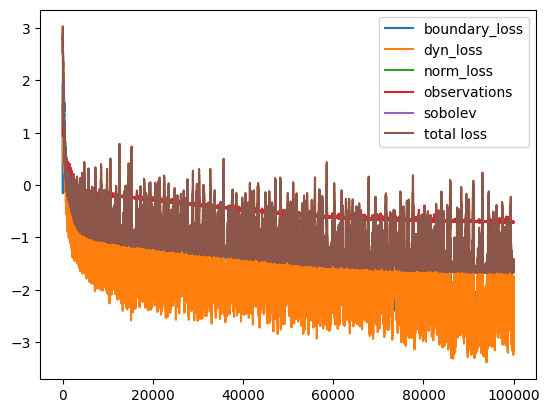

In [20]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solutions learned by the PINN

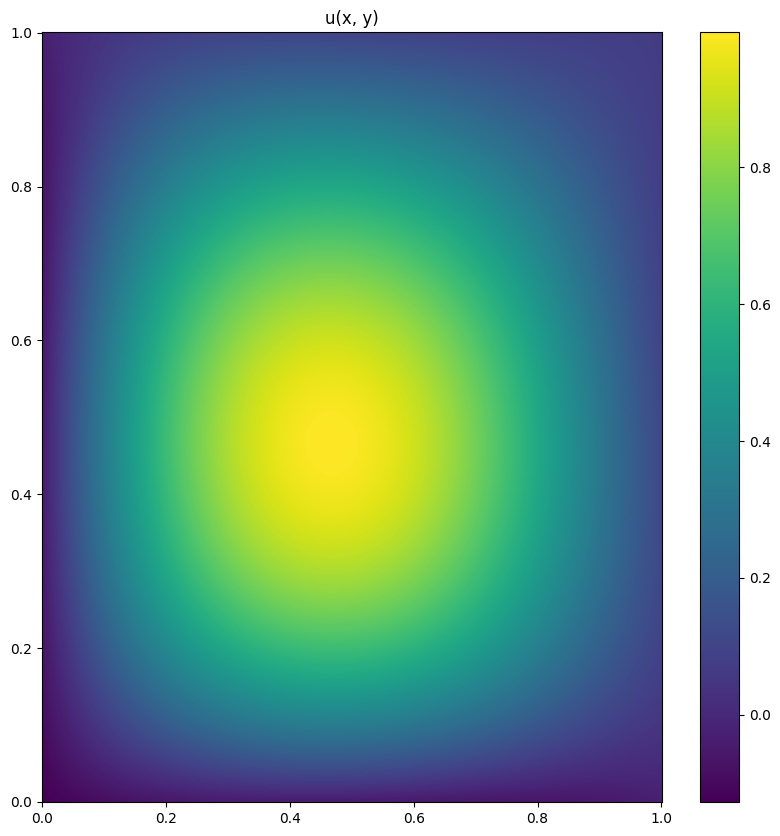

In [21]:
u_est = lambda x: u(x, params)[0]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(u_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="u(x, y)")

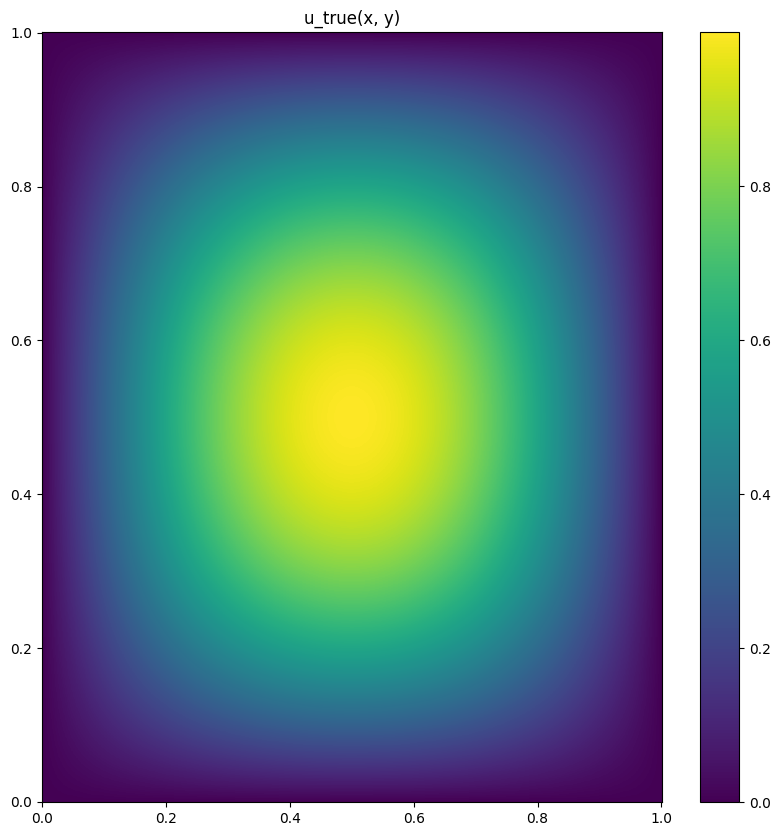

In [22]:
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(u_true, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="u_true(x, y)")

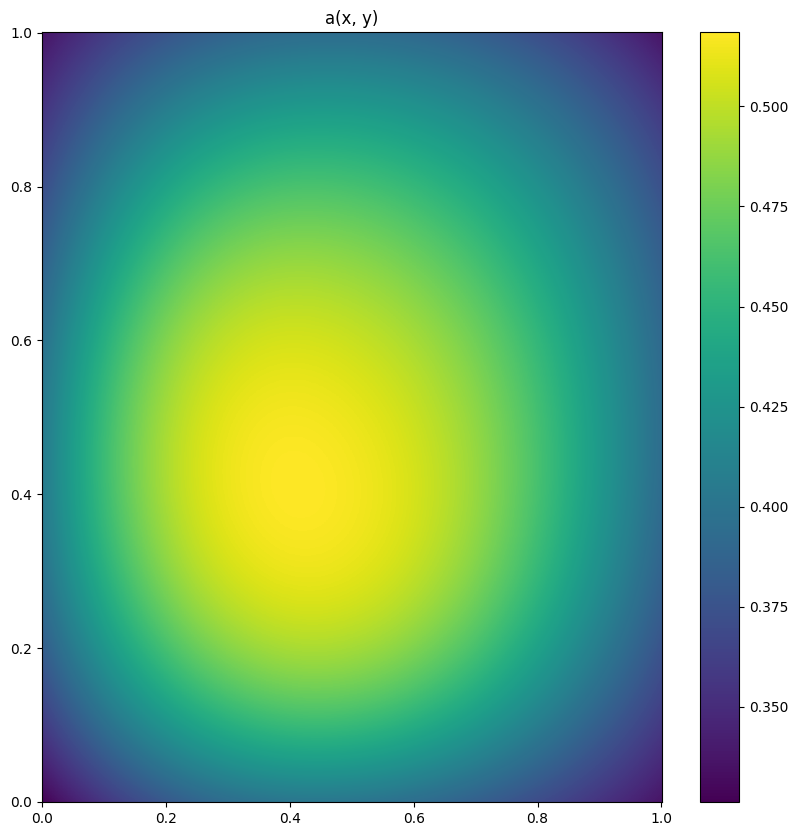

In [23]:
a_est = lambda x: u(x, params)[1]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(a_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="a(x, y)")

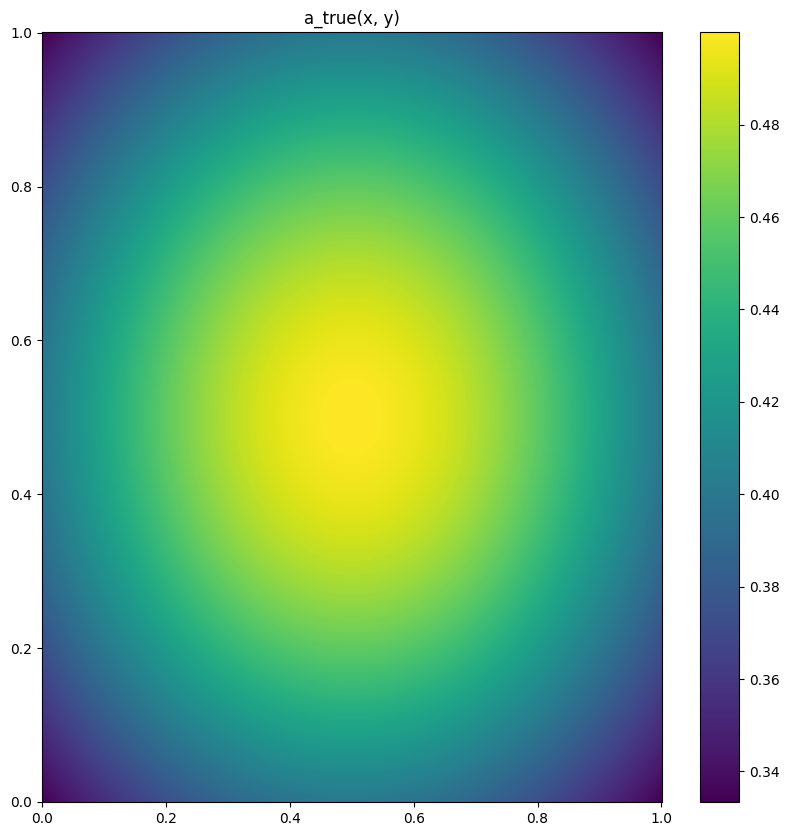

In [24]:
a_true = a_boundary
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.data.plot2d(a_true, xy_data=val_xydata, times=None, cmap="viridis", figsize=(10,10), title="a_true(x, y)")

## Conclusion

The results have been computed around 4 minutes on a Nvidia T600 GPU (100000/100000 [03:52<00:00, 407.96it/s]). Specific finetuning and longer training would bring more precise results.